### Step 1: Reading and Understanding the Data

In [1]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sqlite3
conn = sqlite3.connect('research.db')


###  Fetch all accounts

In [2]:
cur = conn.cursor()
cur.execute("select \"Id\", \"RecordType.Name\",\"Industry\",\"Business_Type__c\",\"Country__c\",\"Is_External__c\",\"ParentId\"from \"Account\" union \
select \"Id\", \"RecordType.Name\",\"Education\" as \"Industry\",\"Not for profit\" as \"Business_Type__c\",\"Australia\" as \"Country__c\", \
\"Is_External__c\",\"ParentId\" from \"Account_internal\"")
accounts_all = cur.fetchall()
accounts_all= pd.DataFrame(accounts_all)
accounts_all.columns= ['AccountID', 'AccountType','Industry','BusinessType','Country','Internal_External','ParentAccount']
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Industry'] = 'Education'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'BusinessType'] = 'University'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Country'] = 'Australia' 
accounts_all['f_Australia']=accounts_all['Country'].apply(lambda x: 1 if x == 'Australia' else 0)
accounts_all["f_parent"]=accounts_all['ParentAccount'].notnull().astype(int)
accounts_all=accounts_all.drop(["ParentAccount"],axis=1)
accounts_all=accounts_all.drop(["Country"],axis=1)

In [3]:
cur.execute("select * from \"Opportunities\"")
Opportunity_raw = cur.fetchall()
Opportunity_raw= pd.DataFrame(Opportunity_raw)
Opportunity_raw.columns= ['ID', 'outcome','status_reason','init_OppType','Opptype','Supppoted', 
                          'createDate','est_closeDate','act_closeDate', 'est_amt','est_proj','act_amt',
                          'act_proj','bd_cluster','bd_div','aud_type','course_type','accountId',
                          'cust_contact','lead_aca_contact','lead_faculty','lead_school','lead_dep','supp_1'
                          ,'supp_2','ownerid','parent_opp'
                         ]
Opportunity_raw.loc[Opportunity_raw["lead_faculty"].isnull(),"lead_faculty"] = "Missing Faculty"
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = Opportunity_raw["est_amt"] 
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = 0
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = Opportunity_raw["est_proj"]
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = 0
Opportunity_raw.loc[Opportunity_raw["act_closeDate"].isnull(),"act_closeDate"] = Opportunity_raw["est_closeDate"]
Opportunity_raw['createDate'] = Opportunity_raw['createDate'].str[:10]
Opportunity_raw['createDate'] = pd.to_datetime(Opportunity_raw['createDate'])
Opportunity_raw['act_closeDate'] = pd.to_datetime(Opportunity_raw['act_closeDate'])
Opportunity_raw['closeDate_month'] = Opportunity_raw['act_closeDate'].dt.month
Opportunity_raw['createDate_month'] = Opportunity_raw['createDate'].dt.month
Opportunity_raw['closeDate_year'] = Opportunity_raw['act_closeDate'].dt.year
Opportunity_raw['createDate_year'] = Opportunity_raw['createDate'].dt.year
Opportunity_raw['days_diff']=(Opportunity_raw['act_closeDate']-Opportunity_raw['createDate']).dt.days
Opportunity_raw["f_parent_opp"]=Opportunity_raw['parent_opp'].notnull().astype(int)
Opportunity_raw_after=Opportunity_raw[['outcome','Opptype','Supppoted', 
                          'days_diff','closeDate_month','createDate_month','closeDate_year','createDate_year','act_amt',
                          'act_proj','accountId',
                          'lead_faculty','f_parent_opp']]


In [4]:
merged=Opportunity_raw_after.merge(accounts_all, left_on='accountId', right_on='AccountID',how='left')
merged=merged.drop(["accountId","AccountID"],axis=1)
merged_data=merged[(merged.outcome == 'Closed Lost')|(merged.outcome =='Closed Won')]

In [5]:
merged_data.to_csv('merged_data.csv',index=False)

In [6]:
print(len(merged_data))
merged_data=merged_data[~merged_data.AccountType.isna()]
merged_data=merged_data[~merged_data.BusinessType.isna()]
print(len(merged_data))
merged_data.to_csv('merged_data_final.csv',index=False)

X = merged_data.iloc[:, 1:].values
y = merged_data.iloc[:, 0].values


6335
5689


In [7]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])
X[:,9] = labelencoder_X.fit_transform(X[:,9])
X[:,11] = labelencoder_X.fit_transform(X[:,11])
X[:,12] = labelencoder_X.fit_transform(X[:,12])
X[:,13] = labelencoder_X.fit_transform(X[:,13])
X[:,14] = labelencoder_X.fit_transform(X[:,14])


labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (4551, 17) (4551,)
Test (1138, 17) (1138,)


In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.64
Accuracy of Logistic regression classifier on test set: 0.66


In [14]:
scores = cross_val_score(estimator=logreg, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.64850615 0.64674868 0.63796134 0.64674868 0.63796134 0.64674868
 0.64674868 0.64674868 0.64674868 0.64788732]


Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00000
Feature: 2, Score: -0.00002
Feature: 3, Score: -0.00000
Feature: 4, Score: -0.00000
Feature: 5, Score: -0.00015
Feature: 6, Score: -0.00015
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000
Feature: 16, Score: -0.00000


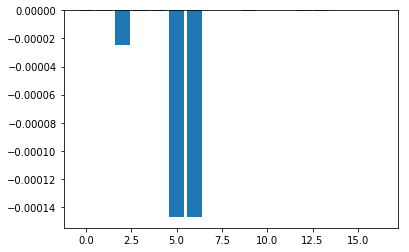

In [27]:
# get importance
importance = logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [15]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.84


In [16]:
scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.86115993 0.86115993 0.75043937 0.80492091 0.65905097 0.81898067
 0.85588752 0.85061511 0.85413005 0.8028169 ]


Feature: 0, Score: 0.04510
Feature: 1, Score: 0.00994
Feature: 2, Score: 0.13809
Feature: 3, Score: 0.04424
Feature: 4, Score: 0.02876
Feature: 5, Score: 0.09057
Feature: 6, Score: 0.01392
Feature: 7, Score: 0.06289
Feature: 8, Score: 0.43949
Feature: 9, Score: 0.05314
Feature: 10, Score: 0.00355
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.02821
Feature: 13, Score: 0.03197
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00621
Feature: 16, Score: 0.00392


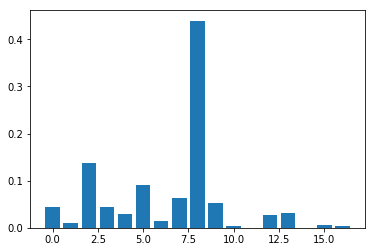

In [29]:
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Accuracy of Random Forest  Classifier on training set: 1.00
Accuracy of Random Forest Classifier on test set: 1.00
Feature: 0, Score: 0.03675
Feature: 1, Score: 0.02733
Feature: 2, Score: 0.12828
Feature: 3, Score: 0.04463
Feature: 4, Score: 0.03954
Feature: 5, Score: 0.05469
Feature: 6, Score: 0.02859
Feature: 7, Score: 0.17012
Feature: 8, Score: 0.29383
Feature: 9, Score: 0.07396
Feature: 10, Score: 0.01476
Feature: 11, Score: 0.00026
Feature: 12, Score: 0.03416
Feature: 13, Score: 0.03690
Feature: 14, Score: 0.00051
Feature: 15, Score: 0.00836
Feature: 16, Score: 0.00732


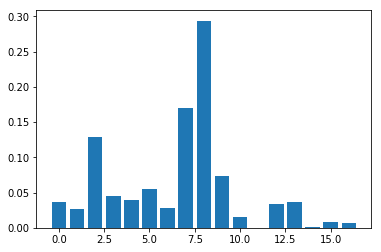

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
# fit the model
model.fit(X, y)

print('Accuracy of Random Forest  Classifier on training set: {:.2f}'
     .format(model.score(X_train, y_train)))
print('Accuracy of Random Forest Classifier on test set: {:.2f}'
     .format(model.score(X_test, y_test)))
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.87
Accuracy of K-NN classifier on test set: 0.85


In [36]:
scores = cross_val_score(estimator=knn, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.86994728 0.82952548 0.73989455 0.82425308 0.77504394 0.84182777
 0.83479789 0.85940246 0.8172232  0.8221831 ]


In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.69
Accuracy of LDA classifier on test set: 0.68


In [38]:
scores = cross_val_score(estimator=lda, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.5940246  0.65553603 0.68365554 0.69947276 0.63620387 0.69068541
 0.70826011 0.62565905 0.65553603 0.6443662 ]


In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.64
Accuracy of GNB classifier on test set: 0.66


In [40]:
scores = cross_val_score(estimator=gnb, X=X, y=y, cv=10, n_jobs=4)
print(scores)

[0.543058   0.63620387 0.61511424 0.56414763 0.68189807 0.76449912
 0.4340949  0.5026362  0.47275923 0.52640845]


In [23]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.65
Accuracy of SVM classifier on test set: 0.64


In [42]:
scores = cross_val_score(estimator=svm, X=X, y=y, cv=10, n_jobs=4)
print(scores)


[0.66256591 0.6344464  0.5659051  0.64323374 0.66080844 0.61862917
 0.66256591 0.64850615 0.67135325 0.64964789]
